In [1]:
# code block for imports 
import pandas as pd 
import numpy as np
import sqlite3
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import folium
from folium import plugins
from folium.plugins import HeatMap
import seaborn as sns

In [2]:
conn = sqlite3.connect('cs506MAPC.db')

## Display first 10 Providers 

In [3]:
qrystr ="SELECT DISTINCT t1.ProviderName,substr(t1.BlockCode,0,12) as tractNum,t1.MaxAdDown,t1.MaxAdUp, t2.town, t3.Longitude, t3.Latitude FROM FCC_DATA_T t1, censusblocks_t t2, CityLongLat_t t3 WHERE substr(t1.BlockCode,0,12) = t2.blockcode AND t2.town = t3.town ORDER BY t2.town ASC"


#convert query results into dataframe
df_filtered_providers = pd.read_sql_query(qrystr, conn)
print(df_filtered_providers.head(10))

                     ProviderName     tractNum  MaxAdDown  MaxAdUp      town  \
0  MCI Communications Corporation  25023520100        0.0      0.0  ABINGTON   
1  MCI Communications Corporation  25023520201        0.0      0.0  ABINGTON   
2  MCI Communications Corporation  25023520202        0.0      0.0  ABINGTON   
3          Crown Castle Fiber LLC  25023520100        0.0      0.0  ABINGTON   
4          Crown Castle Fiber LLC  25023520201        0.0      0.0  ABINGTON   
5          Crown Castle Fiber LLC  25023520202        0.0      0.0  ABINGTON   
6                    ViaSat, Inc.  25023520100      100.0      3.0  ABINGTON   
7                    ViaSat, Inc.  25023520201      100.0      3.0  ABINGTON   
8                    ViaSat, Inc.  25023520202      100.0      3.0  ABINGTON   
9          U.S. TelePacific Corp.  25023520202        0.0      0.0  ABINGTON   

   Longitude  Latitude  
0     -70.96     42.12  
1     -70.96     42.12  
2     -70.96     42.12  
3     -70.96     42

## Non Zero Providers

In [4]:
qryStr2 = "SELECT DISTINCT t1.ProviderName,substr(t1.BlockCode,0,12) as tractNum,t1.MaxAdDown,t1.MaxAdUp, t2.town, t3.Longitude, t3.Latitude FROM FCC_DATA_T t1, censusblocks_t t2, CityLongLat_t t3 WHERE MaxAdDown != 0.0 AND MaxAdUp != 0.0 and substr(t1.BlockCode,0,12) = t2.blockcode AND t2.town = t3.town ORDER BY t2.town ASC"
df_filtered_non_zero_providers = pd.read_sql_query(qryStr2, conn)
print(df_filtered_non_zero_providers.head(10))


                        ProviderName     tractNum  MaxAdDown  MaxAdUp  \
0                       ViaSat, Inc.  25023520100      100.0    3.000   
1                       ViaSat, Inc.  25023520201      100.0    3.000   
2                       ViaSat, Inc.  25023520202      100.0    3.000   
3  COMCAST CABLE COMMUNICATIONS, LLC  25023520100      987.0   35.000   
4  COMCAST CABLE COMMUNICATIONS, LLC  25023520201      987.0   35.000   
5  COMCAST CABLE COMMUNICATIONS, LLC  25023520202      987.0   35.000   
6           Verizon New England Inc.  25023520202      940.0  880.000   
7           Verizon New England Inc.  25023520202        5.0    0.768   
8           Verizon New England Inc.  25023520202       15.0    1.000   
9           Verizon New England Inc.  25023520202       10.0    1.000   

       town  Longitude  Latitude  
0  ABINGTON     -70.96     42.12  
1  ABINGTON     -70.96     42.12  
2  ABINGTON     -70.96     42.12  
3  ABINGTON     -70.96     42.12  
4  ABINGTON     -70.9

## Zero Providers

In [5]:
qryStr3 = "SELECT DISTINCT t1.ProviderName,substr(t1.BlockCode,0,12) as tractNum,t1.MaxAdDown,t1.MaxAdUp, t2.town, t3.Longitude, t3.Latitude FROM FCC_DATA_T t1, censusblocks_t t2, CityLongLat_t t3 WHERE MaxAdDown = 0 AND MaxAdUp = 0 and substr(t1.BlockCode,0,12) = t2.blockcode AND t2.town = t3.town ORDER BY t2.town ASC"
df_filtered_zero_providers = pd.read_sql_query(qryStr3, conn)
print(df_filtered_zero_providers.head(10))

                        ProviderName     tractNum  MaxAdDown  MaxAdUp  \
0     MCI Communications Corporation  25023520100        0.0      0.0   
1     MCI Communications Corporation  25023520201        0.0      0.0   
2     MCI Communications Corporation  25023520202        0.0      0.0   
3             Crown Castle Fiber LLC  25023520100        0.0      0.0   
4             Crown Castle Fiber LLC  25023520201        0.0      0.0   
5             Crown Castle Fiber LLC  25023520202        0.0      0.0   
6             U.S. TelePacific Corp.  25023520202        0.0      0.0   
7  Broadview Networks Holdings, Inc.  25023520100        0.0      0.0   
8  COMCAST CABLE COMMUNICATIONS, LLC  25023520201        0.0      0.0   
9  COMCAST CABLE COMMUNICATIONS, LLC  25023520100        0.0      0.0   

       town  Longitude  Latitude  
0  ABINGTON     -70.96     42.12  
1  ABINGTON     -70.96     42.12  
2  ABINGTON     -70.96     42.12  
3  ABINGTON     -70.96     42.12  
4  ABINGTON     -70.9

## Max Providers Per Area

In [6]:
town_dict = {}
towns = df_filtered_zero_providers['town']
providers = df_filtered_zero_providers['ProviderName']
df_towns_providers = pd.concat([towns, providers], axis=1)
numpy_arr = df_towns_providers.to_numpy()
for i in range(len(numpy_arr)):
    town_name = numpy_arr[i][0]
    if town_name not in town_dict.keys():
        town_dict[town_name] = [numpy_arr[i][1]]
    elif numpy_arr[i][1] not in town_dict.get(town_name):
        town_dict[town_name].append(numpy_arr[i][1])
    else:
        continue

num_providers_dict = {}
for key in town_dict.keys():
    num_providers_dict[key] = len(town_dict.get(key))

df_num_providers = pd.DataFrame(num_providers_dict.items(), columns=['Town', 'ProviderCount'])
print(df_num_providers)

                Town  ProviderCount
0           ABINGTON              9
1    ACUSHNET CENTER              4
2              ADAMS              5
3        AGAWAM TOWN             13
4      AMESBURY TOWN              8
..               ...            ...
181       WINCHENDON              6
182       WINCHESTER              7
183    WINTHROP TOWN              6
184           WOBURN             17
185        WORCESTER             18

[186 rows x 2 columns]


## Display top/bottom 5 areas by number of providers (& Revere, Everett, Quincy)

               Town  ProviderCount
0         CAMBRIDGE             21
1            BOSTON             18
2         WORCESTER             18
3        SOMERVILLE             17
4           WALTHAM             17
5   BARNSTABLE TOWN              1
6            HANSON              1
7       OCEAN GROVE              1
8     SOUTH AMHERST              1
9           HOLLAND              2
10          EVERETT             11
11           QUINCY             13
12           REVERE             10


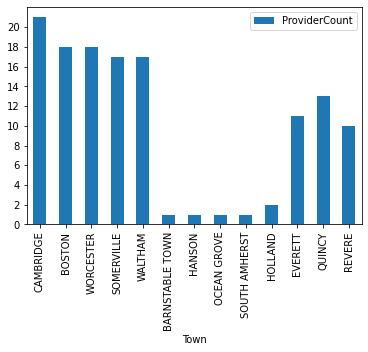

In [7]:
five_most_providers = dict(sorted(num_providers_dict.items(), key=lambda item: item[1], reverse=True)[:5])
five_least_providers = dict(sorted(num_providers_dict.items(), key=lambda item: item[1])[:5])
everett_providers = {'EVERETT': num_providers_dict.get('EVERETT')}
quincy_providers = {'QUINCY': num_providers_dict.get('QUINCY')}
revere_providers = {'REVERE': num_providers_dict.get('REVERE')}
plot_providers = {**five_most_providers, **five_least_providers, **everett_providers, **quincy_providers, **revere_providers}
df_plot_providers = pd.DataFrame(plot_providers.items(), columns=['Town', 'ProviderCount'])

y_max_tick = max(plot_providers.values())

print(df_plot_providers)
df_plot_providers.plot(x='Town', y='ProviderCount', kind='bar')
plt.yticks(np.arange(0, y_max_tick, 2))
plt.show()

## MaxAdDown

   MaxAdDown            Town
0     1000.0       WESTFIELD
1     1000.0  AMHERST CENTER
2      500.0          WOBURN
3      500.0      WINCHESTER
4      500.0       WELLESLEY
5      500.0  WATERTOWN TOWN
6      500.0         WALTHAM
7      500.0        STONEHAM
8      500.0      SOMERVILLE
9      500.0          SAUGUS


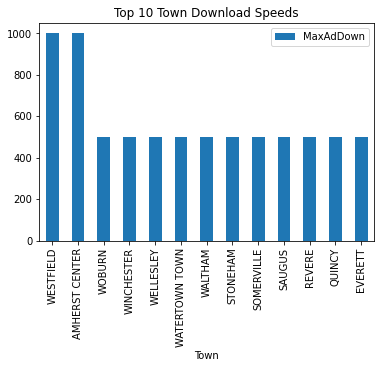

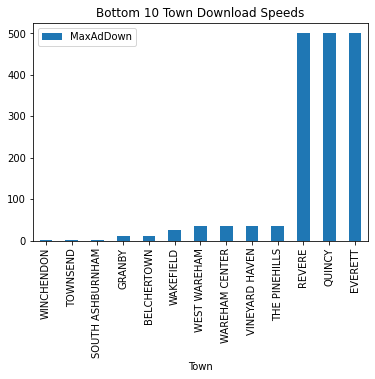

In [8]:
qryStr4 = "SELECT DISTINCT t1.MaxAdDown, t2.town as Town FROM FCC_DATA_T t1, censusblocks_t t2, CityLongLat_t t3 WHERE MaxAdDown != 0.0 AND MaxAdUp != 0.0 and substr(t1.BlockCode,0,12) = t2.blockcode AND t2.town = t3.town GROUP BY t2.town ORDER BY MaxAdDown DESC"
df_filtered_max_down = pd.read_sql_query(qryStr4, conn)
print(df_filtered_max_down.head(10))

top_ten = df_filtered_max_down.nlargest(10, ['MaxAdDown'])
bottom_ten = df_filtered_max_down.nsmallest(10, ['MaxAdDown'])
revere = df_filtered_max_down.loc[df_filtered_max_down['Town'] == 'REVERE']
quincy = df_filtered_max_down.loc[df_filtered_max_down['Town'] == 'QUINCY']
everett = df_filtered_max_down.loc[df_filtered_max_down['Town'] == 'EVERETT']

combined_max_down_top = pd.concat([top_ten, revere, quincy, everett], axis=0)
combined_max_down_top = combined_max_down_top.reset_index(drop=True)
combined_max_down_bottom = pd.concat([bottom_ten, revere, quincy, everett], axis=0)
combined_max_down_bottom = combined_max_down_bottom.reset_index(drop=True)

combined_max_down_top.plot(x='Town', y='MaxAdDown', kind='bar', title = "Top 10 Town Download Speeds")
plt.show()

combined_max_down_bottom.plot(x='Town', y='MaxAdDown', kind='bar', title = "Bottom 10 Town Download Speeds")
plt.show()

## MaxAdUp

   MaxAdUp            Town
0   1000.0       WESTFIELD
1   1000.0  AMHERST CENTER
2    150.0    WEST CONCORD
3     20.0          WOBURN
4     20.0      WINCHESTER
5     20.0       WELLESLEY
6     20.0  WATERTOWN TOWN
7     20.0         WALTHAM
8     20.0        STONEHAM
9     20.0      SOMERVILLE


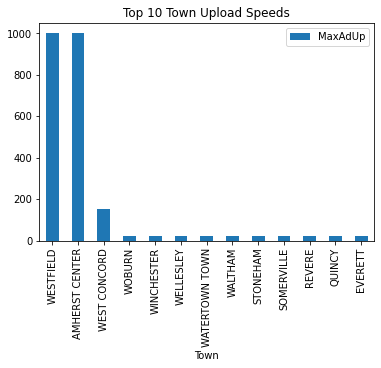

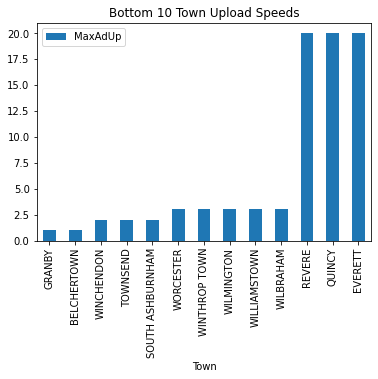

In [9]:
qryStr5 = "SELECT DISTINCT t1.MaxAdUp, t2.town as Town FROM FCC_DATA_T t1, censusblocks_t t2, CityLongLat_t t3 WHERE MaxAdDown != 0.0 AND MaxAdUp != 0.0 and substr(t1.BlockCode,0,12) = t2.blockcode AND t2.town = t3.town GROUP BY t2.town ORDER BY MaxAdUp DESC"
df_filtered_max_up = pd.read_sql_query(qryStr5, conn)
print(df_filtered_max_up.head(10))

top_ten = df_filtered_max_up.nlargest(10, ['MaxAdUp'])
bottom_ten = df_filtered_max_up.nsmallest(10, ['MaxAdUp'])
revere = df_filtered_max_up.loc[df_filtered_max_up['Town'] == 'REVERE']
quincy = df_filtered_max_up.loc[df_filtered_max_up['Town'] == 'QUINCY']
everett = df_filtered_max_up.loc[df_filtered_max_up['Town'] == 'EVERETT']

combined_max_up_top = pd.concat([top_ten, revere, quincy, everett], axis=0)
combined_max_up_top = combined_max_up_top.reset_index(drop=True)
combined_max_up_bottom = pd.concat([bottom_ten, revere, quincy, everett], axis=0)
combined_max_up_bottom = combined_max_up_bottom.reset_index(drop=True)

combined_max_up_top.plot(x='Town', y='MaxAdUp', kind='bar', title = "Top 10 Town Upload Speeds")
plt.show()

combined_max_up_bottom.plot(x='Town', y='MaxAdUp', kind='bar', title = "Bottom 10 Town Upload Speeds")
plt.show()

## Median Income  (Census Tracks)

In [10]:
qryStr6 = "SELECT t2.Town as Town, AVG(t1.mhi) as 'Average Median Income' FROM median_income_t t1, censusblocks_t t2 WHERE t2.blockcode = t1.ct10_id and t1.mhi > 1 GROUP BY t2.Town;"
town_median_income  = pd.read_sql_query(qryStr6, conn)
town_median_income

,Town,Average Median Income
0,ABINGTON,89531.333333
1,ACUSHNET CENTER,69091.500000
2,ADAMS,50431.000000
3,AGAWAM TOWN,70442.500000
4,AMESBURY TOWN,83022.250000
...,...,...
181,WINCHENDON,74986.000000
182,WINCHESTER,160758.800000
183,WINTHROP TOWN,73106.200000
184,WOBURN,87139.285714


In [11]:
town_median_income.sort_values(by=['Average Median Income'])
top_five_towns = town_median_income.nlargest(5, ['Average Median Income'])
bottom_five_towns = town_median_income.nsmallest(5, ['Average Median Income'])
revere = town_median_income.loc[town_median_income['Town'] == 'REVERE']
quincy = town_median_income.loc[town_median_income['Town'] == 'QUINCY']
everett = town_median_income.loc[town_median_income['Town'] == 'EVERETT']
combined_median_income_df = pd.concat([top_five_towns, bottom_five_towns, revere, quincy, everett], axis=0)
combined_median_income_df = combined_median_income_df.reset_index(drop=True)
combined_median_income_df

,Town,Average Median Income
0,DOVER,224784.000000
1,WELLESLEY,191841.500000
2,BOXFORD,174340.000000
3,LEXINGTON,174233.166667
4,HOPKINTON,167733.500000
5,SPRINGFIELD,38017.162162
6,NORTH ADAMS,38142.500000
7,LAWRENCE,39653.166667
8,HOLYOKE,40761.636364
9,FALL RIVER,43967.920000


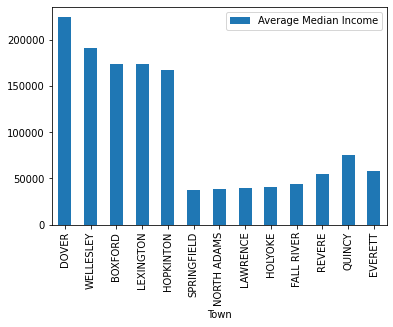

In [12]:
combined_median_income_df.plot(x='Town', y='Average Median Income', kind='bar') 
plt.show()

In [13]:
qryStr7 = "SELECT t2.Town as Town, ROUND(AVG(t1.MaxAdDown),2) as AverageMaxDown, ROUND(AVG(t1.MaxAdUp),2) as AverageMaxUp FROM fcc_data_t t1, censusblocks_t t2 WHERE substr(t1.BlockCode,0,12) = t2.blockcode GROUP BY t2.TOWN"
town_average_speeds  = pd.read_sql_query(qryStr7, conn)
town_average_speeds

,Town,AverageMaxDown,AverageMaxUp
0,ABINGTON,250.73,111.99
1,ACUSHNET CENTER,170.98,25.24
2,ADAMS,178.95,7.60
3,AGAWAM TOWN,144.87,5.77
4,AMESBURY TOWN,144.11,5.67
...,...,...,...
183,WINCHENDON,115.36,4.68
184,WINCHESTER,261.78,116.97
185,WINTHROP TOWN,176.10,6.78
186,WOBURN,281.54,92.69


In [14]:
dover = town_average_speeds.loc[town_average_speeds['Town'] == 'DOVER']
wellesley = town_average_speeds.loc[town_average_speeds['Town'] == 'WELLESLEY']
boxford = town_average_speeds.loc[town_average_speeds['Town'] == 'BOXFORD']
lexington = town_average_speeds.loc[town_average_speeds['Town'] == 'LEXINGTON']
hopkinton = town_average_speeds.loc[town_average_speeds['Town'] == 'HOPKINTON']
springfield = town_average_speeds.loc[town_average_speeds['Town'] == 'SPRINGFIELD']
north_adams = town_average_speeds.loc[town_average_speeds['Town'] == 'NORTH ADAMS']
lawrence = town_average_speeds.loc[town_average_speeds['Town'] == 'LAWRENCE']
holyoke = town_average_speeds.loc[town_average_speeds['Town'] == 'HOLYOKE']
fall_river = town_average_speeds.loc[town_average_speeds['Town'] == 'FALL RIVER']
revere = town_average_speeds.loc[town_average_speeds['Town'] == 'REVERE']
quincy = town_average_speeds.loc[town_average_speeds['Town'] == 'QUINCY']
everett = town_average_speeds.loc[town_average_speeds['Town'] == 'EVERETT']

combined_average_speed_df = pd.concat([dover, wellesley, boxford, lexington, hopkinton, springfield, north_adams, lawrence, holyoke, fall_river, revere, quincy, everett], axis=0)
combined_average_speed_df = combined_average_speed_df.reset_index(drop=True)
combined_average_speed_df

,Town,AverageMaxDown,AverageMaxUp
0,DOVER,266.60,116.52
1,WELLESLEY,259.47,114.26
2,BOXFORD,229.41,98.39
3,LEXINGTON,281.84,92.27
4,HOPKINTON,253.57,112.75
5,SPRINGFIELD,143.97,5.65
6,NORTH ADAMS,181.18,8.01
7,LAWRENCE,249.54,110.73
8,HOLYOKE,135.08,5.35
9,FALL RIVER,147.38,5.87


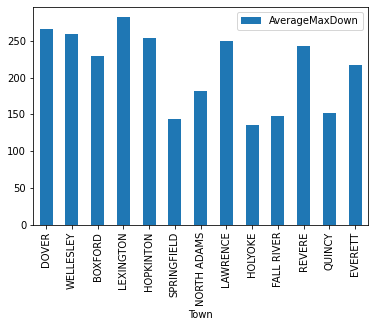

In [15]:
combined_average_speed_df.plot(x='Town', y='AverageMaxDown', kind='bar') 
plt.show()

# add Average Max Up

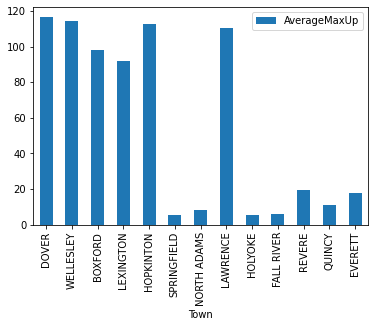

In [16]:
combined_average_speed_df.plot(x='Town', y='AverageMaxUp', kind='bar') 
plt.show()

In [17]:
median_income_and_speed_df = combined_average_speed_df
median_income_and_speed_df['Average Median Income'] = combined_median_income_df['Average Median Income']
median_income_and_speed_df

,Town,AverageMaxDown,AverageMaxUp,Average Median Income
0,DOVER,266.60,116.52,224784.000000
1,WELLESLEY,259.47,114.26,191841.500000
2,BOXFORD,229.41,98.39,174340.000000
3,LEXINGTON,281.84,92.27,174233.166667
4,HOPKINTON,253.57,112.75,167733.500000
5,SPRINGFIELD,143.97,5.65,38017.162162
6,NORTH ADAMS,181.18,8.01,38142.500000
7,LAWRENCE,249.54,110.73,39653.166667
8,HOLYOKE,135.08,5.35,40761.636364
9,FALL RIVER,147.38,5.87,43967.920000


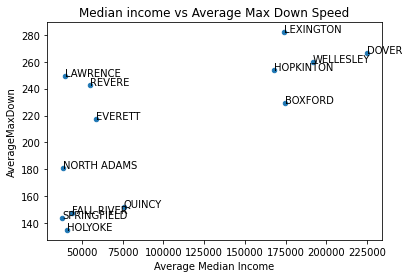

In [18]:
ax1 = median_income_and_speed_df.plot(kind='scatter', x='Average Median Income', y='AverageMaxDown', title='Median income vs Average Max Down Speed',)    

# annotate points in axis
for idx, row in median_income_and_speed_df.iterrows():
    ax1.annotate(row['Town'], (row['Average Median Income'], row['AverageMaxDown']))

plt.show()


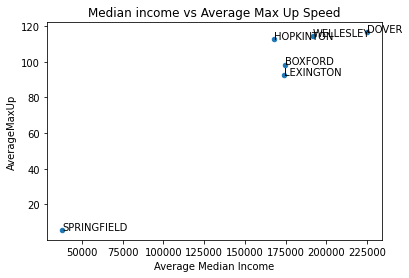

In [19]:
ax2 = median_income_and_speed_df[:6].plot(kind='scatter', x='Average Median Income', y='AverageMaxUp', title='Median income vs Average Max Up Speed',)    

# annotate points in axis
for idx, row in median_income_and_speed_df[:6].iterrows():
    ax2.annotate(row['Town'], (row['Average Median Income'], row['AverageMaxUp']))

plt.show()

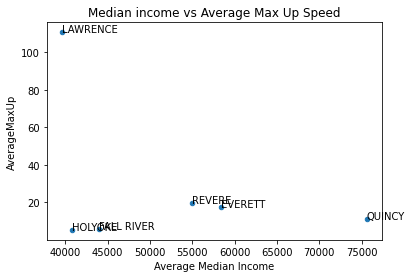

In [20]:
ax3 = median_income_and_speed_df[7:].plot(kind='scatter', x='Average Median Income', y='AverageMaxUp', title='Median income vs Average Max Up Speed',)    

# annotate points in axis
for idx, row in median_income_and_speed_df[7:].iterrows():
    ax3.annotate(row['Town'], (row['Average Median Income'], row['AverageMaxUp']))

plt.show()

In [37]:
qryStr6 = "SELECT t2.Town as Town, ROUND(AVG(t1.MaxAdDown),2) as AverageMaxDown, ROUND(AVG(t1.MaxAdUp),2) as AverageMaxUp, t3.* FROM fcc_data_t t1, censusblocks_t t2, race_ethnicity_t t3 WHERE substr(t1.BlockCode,0,12) = t2.blockcode  AND t2.blockcode = t3.ct10_id GROUP BY t2.TOWN"
df_averages_percentage = pd.read_sql_query(qryStr6, conn)
print(df_averages_percentage.head(10))



              Town  AverageMaxDown  AverageMaxUp  index      ct10_id   nh_p  \
0         ABINGTON          250.73        111.99   1054  25023520100  97.48   
1  ACUSHNET CENTER          170.98         25.24    218  25005654100  98.23   
2            ADAMS          178.95          7.60     80  25003922100  97.95   
3      AGAWAM TOWN          144.87          5.77    496  25013813206  89.61   
4    AMESBURY TOWN          144.11          5.67    380  25009266200  97.20   
5   AMHERST CENTER          134.88          5.77    519  25015820400  93.70   
6          ANDOVER          211.13         92.44    353  25009254100  97.84   
7        ARLINGTON          330.43        103.19    758  25017356602  95.50   
8            ATHOL          204.69          8.06   1309  25027703100  98.92   
9        ATTLEBORO          151.15          6.92    134  25005631100  93.61   

   nhwhi_p  nhaa_p  nhna_p  nhas_p  nhpi_p  nhoth_p  nhmlt_p  lat_p  
0    88.75    1.33    0.00    3.96     0.0     0.47     2.98

In [38]:
df_averages_percentage = df_averages_percentage.drop(['ct10_id','index'],axis = 1)
df_averages_percentage = df_averages_percentage.rename(columns={"nh_p":"Non-Hispanic","nhwhi_p": "Non-Hispanic White",
                                      "nhaa_p":"Non-Hispanic Black or African American","nhna_p": "Non-Hispanic American Indian and Alaska Native",
                                      "nhas_p":"Non-Hispanic Asian","nhpi_p": "Non-Hispanic Native Hawaiian/Other Pacific Islander",
                                      "nhoth_p":"Non-Hispanic Some Other Races","nhmlt_p": "Non-Hispanic Two or More Races",
                                      "lat_p":"Hispanic/Latino"})

In [39]:
df_averages_percentage.to_csv('MaxSpeed_Race.csv',index = false)

,Town,AverageMaxDown,AverageMaxUp,Non-Hispanic,Non-Hispanic White,Non-Hispanic Black or African American,Non-Hispanic American Indian and Alaska Native,Non-Hispanic Asian,Non-Hispanic Native Hawaiian/Other Pacific Islander,Non-Hispanic Some Other Races,Non-Hispanic Two or More Races,Hispanic/Latino
0,ABINGTON,250.73,111.99,97.48,88.75,1.33,0.00,3.96,0.0,0.47,2.98,2.52
1,ACUSHNET CENTER,170.98,25.24,98.23,89.86,0.00,0.00,1.89,0.0,4.47,2.01,1.77
2,ADAMS,178.95,7.60,97.95,94.62,1.77,0.00,0.00,0.0,0.00,1.56,2.05
3,AGAWAM TOWN,144.87,5.77,89.61,84.31,2.25,0.00,2.32,0.0,0.00,0.73,10.39
4,AMESBURY TOWN,144.11,5.67,97.20,89.84,1.84,0.39,1.73,0.0,0.00,3.41,2.80
...,...,...,...,...,...,...,...,...,...,...,...,...
183,WINCHENDON,115.36,4.68,96.66,92.58,1.00,0.00,1.60,0.0,0.00,1.47,3.34
184,WINCHESTER,261.78,116.97,96.84,73.25,0.34,0.00,20.61,0.0,2.16,0.48,3.16
185,WINTHROP TOWN,176.10,6.78,93.50,92.47,0.43,0.00,0.17,0.0,0.00,0.43,6.50
186,WOBURN,281.54,92.69,90.32,71.32,8.51,0.00,8.73,0.0,1.43,0.34,9.68
